# Определение перспективного тарифа для телеком компании

Информационной базой для данного исследования являются несколько таблиц по поользователям операта сотовой связи.

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана


Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок


Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение


Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя


Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Генеральная задача: Проанализировать поведение клиентов и сделать вывод — какой тариф выгоднее продвигать для компании.

План работы:

 Часть 1. Изучение общей информации:

- [Изученеие файлов с данными, получение общей информации, загрузка библиотек;](#изучение_файлов_с_данными) 
- [Определение базовых проблем в данных](#изучение_файлов_с_данными)

Часть 2. Подготовка данных:

- [Приведение данных к нужным типам;](#Приведение_данных_к_нужным_типам)
- [Нахождение и исправление ошибок и аномалий;](#Нахождение_и_исправление_ошибок_и_аномалий)

Часть 3.  Расчеты дополнительной информации:

- [Расчет затраченных пользователями опций;](#Расчет_затраченных_пользователями_опций)
- [Определение ценовых показателей](#Определение_ценовых_показателей)

Часть 4. Анализ данных и проверка гипотез:

- [Анализ и интерпритация данных;](#Анализ_и_интерпритация_данных)
- [Проверка гипотез;](#Проверка_гипотез)

Часть 5. [Общий вывод](#Общий_вывод)

## Шаг 1 Изучение общей информации

### Изученеие файлов с данными, получение общей информации, загрузка библиотек

<a id='изучение_файлов_с_данными'></a>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
calls = pd.read_csv('/datasets/calls.csv')
display(calls)
calls.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Видим, что в таблице calls столбец id имеет тип object и кроме номера звонка хранит в себе и номер пользователя. Для дальнейшего анализа необходимо будет оставить только номер звонка в столбце id, привести его к типу int и изменить название с id на call_id (что бы не путать с другим id). Столбец с датой необходимо привести к типу datatime.

In [4]:
internet = pd.read_csv('/datasets/internet.csv')
display(internet)
internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Видим, что у нас есть столбец с индексами, не вижу в нём практического смысла, поэтому удалим данный столбец. Для дальнейшего анализа необходимо будет оставить только номер сессии в столбце id, привести его к типу int и изменить название с id на internet_id (что бы не путать с другим id). Изменить тип столбца даты.

In [5]:
messages = pd.read_csv('/datasets/messages.csv')
display(messages)
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Для дальнейшего анализа необходимо будет оставить только номер сессии в столбце id, привести его к типу int и изменить название с id на messages_id (что бы не путать с другим id). Изменить тип столбца даты.

In [6]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
display(tariffs)
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
tariffs.set_axis(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'], axis='columns', inplace=True)

In [8]:
users = pd.read_csv('/datasets/users.csv')
display(users)
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Перевести столбецы с датой к соответствующему формату. Видим пропуски в столбце churn_date, но это нормально, пустые значения значат, что пользователи на момент выгрузки статистики еще активны.

## Шаг 2. Подготовка данных

### Приведение данных к нужным типам

<a id='Приведение_данных_к_нужным_типам'></a>

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [10]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y.%m.%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [11]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [12]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y.%m.%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Нахождение и исправление ошибок и аномалий

<a id='Нахождение_и_исправление_ошибок_и_аномалий'></a>

In [13]:
calls['duration'].value_counts()

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

In [14]:
def ceil_round(round):                 # Функция для округления в большую сторону
    round = math.ceil(round)
    return round

In [15]:
calls['duration'] = calls['duration'].apply(ceil_round) # Округлили минуты разговоров
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


Видим, что большое количество звонков имеют длительность звонка 0.00 минут (примерно 20%), это с большей вероятностью звонки без ответа, так как длительности разговора меньше секунды, да еще и в 20% случаев очень маловероятно, следовательно удаляем данные звонки. 

In [16]:
calls = calls.query('duration != 0')
calls

,id,call_date,duration,user_id
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


In [17]:
internet['Unnamed: 0'].value_counts()

2047     1
95620    1
40249    1
38200    1
60727    1
        ..
51916    1
62155    1
64202    1
58057    1
0        1
Name: Unnamed: 0, Length: 149396, dtype: int64

In [18]:
internet = internet.drop(['Unnamed: 0'], axis = 1) # Убрали столбец 'Unnamed: 0'
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [19]:
internet['mb_used'].value_counts()

0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64

Примерно 13 % значений столбца mb_used имеют нулевые значения, возможно в этих случаях клиенты пользовались интернет-ресурсами, которые не расходуют их трафик. Данное значение лучше уточнить у сборщиков информации.

In [20]:
internet['mb_used'] = internet['mb_used'].apply(ceil_round) # Округлили трафик
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB


In [21]:
def real_id(id):                 # Создали функцию для сохранения в столбце id  только номера операции
    real_id = id.split('_')[1]   # без user_id в начале.
    return real_id

In [22]:
calls['id'] = calls['id'].apply(real_id) # Применили функцию, поменяли названия столбца id и изменили его тип.
calls.set_axis(['call_id', 'call_date', 'duration', 'user_id'], axis = 'columns', inplace=True)
calls['call_id'] = calls['call_id'].astype('int')
calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
call_id      162994 non-null int64
call_date    162994 non-null datetime64[ns]
duration     162994 non-null int64
user_id      162994 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.2 MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
calls.query('call_id == 1000')

,call_id,call_date,duration,user_id
22551,1000,2018-07-17,3,1057
45584,1000,2018-07-01,7,1113
65849,1000,2018-04-28,8,1168
78768,1000,2018-07-29,13,1196
91580,1000,2018-03-02,3,1227
110106,1000,2018-11-07,17,1282
133770,1000,2018-10-03,5,1341
135183,1000,2018-11-04,4,1344
140016,1000,2018-11-04,1,1356
142557,1000,2018-09-24,17,1360


In [24]:
internet['id'] = internet['id'].apply(real_id) # Применили функцию, поменяли названия столбца id и изменили его тип.
internet.set_axis(['internet_id', 'mb_used', 'session_date', 'user_id'], axis = 'columns', inplace=True)
internet['internet_id'] = internet['internet_id'].astype('int')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
internet_id     149396 non-null int64
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.6 MB


In [25]:
messages['id'] = messages['id'].apply(real_id) # Применили функцию, поменяли названия столбца id и изменили его тип.
messages.set_axis(['messages_id', 'message_date', 'user_id'], axis = 'columns', inplace=True)
messages['messages_id'] = messages['messages_id'].astype('int')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
messages_id     123036 non-null int64
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


Удалили звонки продолжительностью 0 минут (как не состоявшиеся звонки), удалили ненужный(дублирующий) столбец Unnamed. Округлили значения минут разговоров и трафика. Оберзали столбец user_id для сохранения только номера пользователя, также поменяли тип этого столбца.

### Расчет затраченных пользователями опций

<a id='Расчет_затраченных_пользователями_опций'></a>

In [26]:
calls['month'] = calls['call_date'].dt.month # Добавляем столбец с номером месяца для создания сводной 
calls.info()                                        # таблицы и расчета необходимых значений

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 5 columns):
call_id      162994 non-null int64
call_date    162994 non-null datetime64[ns]
duration     162994 non-null int64
user_id      162994 non-null int64
month        162994 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 7.5 MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
calls_and_minutes_on_moth = calls.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = ['count', 'sum'])
calls_and_minutes_on_moth # Табличка количество сделанных звонков и израсходованных минут разговора по месяцам
calls_and_minutes_on_moth.columns = ['call_month', 'minutes_month']
display(calls_and_minutes_on_moth)
calls_and_minutes_on_moth.columns

call_month  minutes_month
user_id month                           
1000    5              17            159
        6              28            172
        7              41            340
        8              42            408
        9              46            466
...                   ...            ...
1498    10             30            247
1499    9               8             70
        10             44            449
        11             62            612
        12             56            492

[3168 rows x 2 columns]

Index(['call_month', 'minutes_month'], dtype='object')

In [28]:
#calls_and_minutes = calls.groupby('user_id').agg({'user_id':['count'], 'duration':['sum']})
#calls_and_minutes

In [29]:
messages['month'] = messages['message_date'].dt.month  # Добавили столбец месяца
messages

,messages_id,message_date,user_id,month
0,0,2018-06-27,1000,6
1,1,2018-10-08,1000,10
2,2,2018-08-04,1000,8
3,3,2018-06-16,1000,6
4,4,2018-12-05,1000,12
...,...,...,...,...
123031,179,2018-12-12,1499,12
123032,180,2018-09-28,1499,9
123033,181,2018-09-27,1499,9
123034,182,2018-11-15,1499,11


In [30]:
sum_messages_month = messages.pivot_table(index=['user_id', 'month'], values='messages_id', aggfunc='count')
sum_messages_month # количество отправленных сообщений по месяцам

messages_id
user_id month             
1000    5               22
        6               60
        7               75
        8               81
        9               57
...                    ...
1498    10              42
1499    9               11
        10              48
        11              59
        12              66

[2717 rows x 1 columns]

In [31]:
internet['month'] = internet['session_date'].dt.month     # Добавили столбец месяца
internet

,internet_id,mb_used,session_date,user_id,month
0,0,113,2018-11-25,1000,11
1,1,1053,2018-09-07,1000,9
2,2,1198,2018-06-25,1000,6
3,3,551,2018-08-22,1000,8
4,4,303,2018-09-24,1000,9
...,...,...,...,...,...
149391,152,319,2018-10-03,1499,10
149392,153,491,2018-12-14,1499,12
149393,154,0,2018-10-27,1499,10
149394,155,1247,2018-11-26,1499,11


In [32]:
traffick_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
traffick_month # объем израсходованного интернет-трафика каждого клиента выборки по месяцам

mb_used
user_id month         
1000    5         2256
        6        23257
        7        14016
        8        14070
        9        14581
...                ...
1498    10       20604
1499    9         1848
        10       17809
        11       17984
        12       13077

[3203 rows x 1 columns]

## Определение ценовых показателей

<a id='Определение_ценовых_показателей'></a>

In [33]:
calls_message_internet = calls_and_minutes_on_moth.join([sum_messages_month, traffick_month], how = 'outer')
calls_message_internet     # Совместили 3 таблицы для определения выручки по месяцам

call_month  minutes_month  messages_id  mb_used
user_id month                                                 
1000    5            17.0          159.0         22.0   2256.0
        6            28.0          172.0         60.0  23257.0
        7            41.0          340.0         75.0  14016.0
        8            42.0          408.0         81.0  14070.0
        9            46.0          466.0         57.0  14581.0
...                   ...            ...          ...      ...
1498    10           30.0          247.0         42.0  20604.0
1499    9             8.0           70.0         11.0   1848.0
        10           44.0          449.0         48.0  17809.0
        11           62.0          612.0         59.0  17984.0
        12           56.0          492.0         66.0  13077.0

[3214 rows x 4 columns]

In [34]:
calls_message_internet = calls_message_internet.reset_index(level='month') # Сделали месяц столбцом для расчетов
calls_message_internet

,month,call_month,minutes_month,messages_id,mb_used
user_id,,,,,
1000,5,17.0,159.0,22.0,2256.0
1000,6,28.0,172.0,60.0,23257.0
1000,7,41.0,340.0,75.0,14016.0
1000,8,42.0,408.0,81.0,14070.0
1000,9,46.0,466.0,57.0,14581.0
...,...,...,...,...,...
1498,10,30.0,247.0,42.0,20604.0
1499,9,8.0,70.0,11.0,1848.0
1499,10,44.0,449.0,48.0,17809.0


In [35]:
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [36]:
tariff_data = users.drop(['age', 'first_name', 'last_name'], axis=1) # Выбрали значения для добавления в составную таблицу
tariff_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
user_id       500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 19.7+ KB


In [37]:
calls_message_internet = calls_message_internet.merge(tariff_data, on='user_id', how='outer')
calls_message_internet

,user_id,month,call_month,minutes_month,messages_id,mb_used,churn_date,city,reg_date,tariff
0,1000,5.0,17.0,159.0,22.0,2256.0,NaT,Краснодар,2018-05-25,ultra
1,1000,6.0,28.0,172.0,60.0,23257.0,NaT,Краснодар,2018-05-25,ultra
2,1000,7.0,41.0,340.0,75.0,14016.0,NaT,Краснодар,2018-05-25,ultra
3,1000,8.0,42.0,408.0,81.0,14070.0,NaT,Краснодар,2018-05-25,ultra
4,1000,9.0,46.0,466.0,57.0,14581.0,NaT,Краснодар,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...
3211,1499,10.0,44.0,449.0,48.0,17809.0,NaT,Пермь,2018-09-27,smart
3212,1499,11.0,62.0,612.0,59.0,17984.0,NaT,Пермь,2018-09-27,smart
3213,1499,12.0,56.0,492.0,66.0,13077.0,NaT,Пермь,2018-09-27,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,2018-12-23,Волжский,2018-12-15,ultra


In [38]:
calls_message_internet = calls_message_internet.merge(tariffs, on = 'tariff')
calls_message_internet

,user_id,month,call_month,minutes_month,messages_id,mb_used,churn_date,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,17.0,159.0,22.0,2256.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,28.0,172.0,60.0,23257.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,41.0,340.0,75.0,14016.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,42.0,408.0,81.0,14070.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,46.0,466.0,57.0,14581.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,8.0,70.0,11.0,1848.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3
3212,1499,10.0,44.0,449.0,48.0,17809.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3
3213,1499,11.0,62.0,612.0,59.0,17984.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3
3214,1499,12.0,56.0,492.0,66.0,13077.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3


In [39]:
def revenue(row):
    revenue = row['rub_monthly_fee']
    if row['minutes_month'] > row['minutes_included']:
        revenue += (row['minutes_month'] - row['minutes_included']) * row['rub_per_minute']
    if row['mb_used'] > row['mb_per_month_included']:
        revenue += math.ceil((row['mb_used'] - row['mb_per_month_included']) / 1024) * row['rub_per_gb']
    if row['messages_id'] > row['messages_included']:
        revenue += (row['messages_id'] - row['messages_included']) * row['rub_per_message']
    return revenue

## Анализ и интерпритация данных

<a id='Анализ_и_интерпритация_данных'></a>

In [40]:
calls_message_internet['revenue_month'] = calls_message_internet.apply(revenue, axis=1)
calls_message_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 18 columns):
user_id                  3216 non-null int64
month                    3214 non-null float64
call_month               3168 non-null float64
minutes_month            3168 non-null float64
messages_id              2717 non-null float64
mb_used                  3203 non-null float64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
revenue_month            3216 non-null float64
dtypes: datetime64[ns](2), float64(6), int64(8), obj

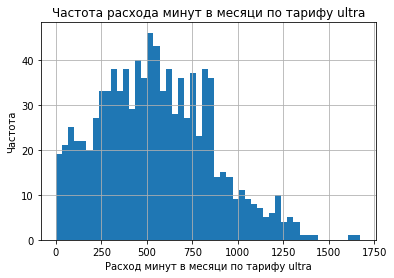

count     947.000000
mean      547.755016
std       305.513385
min         1.000000
25%       311.000000
50%       529.000000
75%       758.000000
max      1673.000000
Name: minutes_month, dtype: float64

In [41]:
calls_message_internet.query('tariff != "smart"')['minutes_month'].plot(kind='hist', y='minutes_month', grid=True, bins=50)
plt.title('Частота расхода минут в месяци по тарифу ultra')
plt.xlabel('Расход минут в месяци по тарифу ultra')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff != "smart"')['minutes_month'].describe()
# Визуализация частоты количества затраченных минут пользователями тарифа ultra в месяц

Исходя из данных гистограм видно, что клиенты с тарифом ultra в основном тратят в месяц 250-800 минут, реже больше, максимум 1673 минуты и никто не тратит 3000 минут, данные в тарифе.

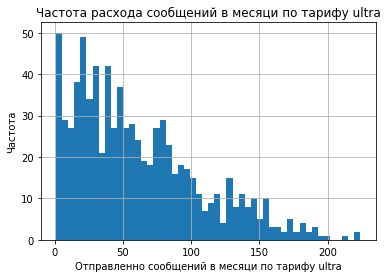

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: messages_id, dtype: float64

In [42]:
calls_message_internet.query('tariff != "smart"')['messages_id'].plot(kind='hist', y='messages_id', grid=True, bins=50)
plt.title('Частота расхода сообщений в месяци по тарифу ultra')
plt.xlabel('Отправленно сообщений в месяци по тарифу ultra')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff != "smart"')['messages_id'].describe()

Подавляющее число пользователей тарфиа ultra отпарвляют в месяц 0-80 сообщений из заявленных в тарифе 1000. 

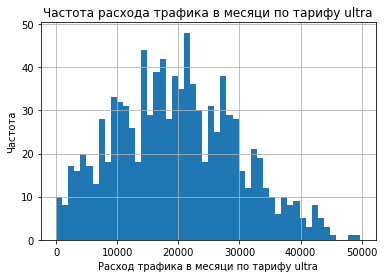

count      975.000000
mean     19686.767179
std       9952.057054
min          0.000000
25%      12020.500000
50%      19411.000000
75%      26920.500000
max      49789.000000
Name: mb_used, dtype: float64

In [43]:
calls_message_internet.query('tariff != "smart"')['mb_used'].plot(kind='hist', y='mb_used', grid=True, bins=50)
plt.title('Частота расхода трафика в месяци по тарифу ultra')
plt.xlabel('Расход трафика в месяци по тарифу ultra')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff != "smart"')['mb_used'].describe()

Подавляющее число пользователей тарфиа ultra тратят 15000 - 27000 мб в месяц, при 30720 доступных мб. в тарифе. Чуть меньше 25% людей тратят больше трафика чем заявленно в тарифе. 

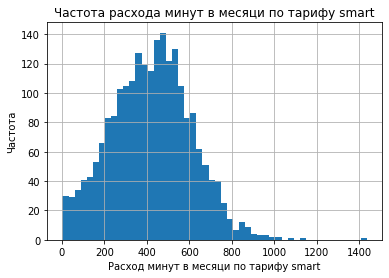

count    2221.000000
mean      419.440342
std       188.992403
min         2.000000
25%       285.000000
50%       423.000000
75%       546.000000
max      1435.000000
Name: minutes_month, dtype: float64

In [44]:
calls_message_internet.query('tariff == "smart"')['minutes_month'].plot(kind='hist', y='minutes_month', grid=True, bins=50)
plt.title('Частота расхода минут в месяци по тарифу smart')
plt.xlabel('Расход минут в месяци по тарифу smart')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff == "smart"')['minutes_month'].describe()
# Визуализация частоты количества затраченных минут пользователями тарифа smart в месяц

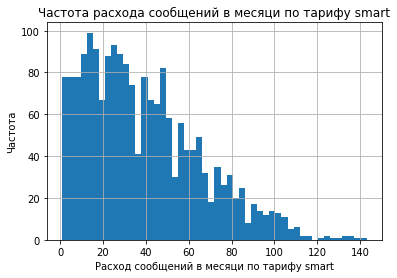

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: messages_id, dtype: float64

In [45]:
calls_message_internet.query('tariff == "smart"')['messages_id'].plot(kind='hist', y='messages_id', grid=True, bins=50)
plt.title('Частота расхода сообщений в месяци по тарифу smart')
plt.xlabel('Расход сообщений в месяци по тарифу smart')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff == "smart"')['messages_id'].describe()

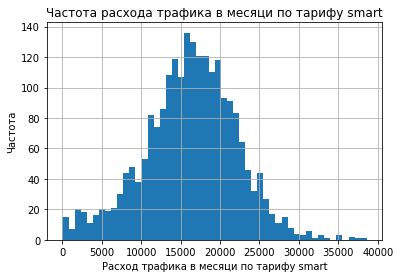

count     2228.000000
mean     16236.472621
std       5868.824472
min          0.000000
25%      12668.500000
50%      16532.000000
75%      20068.000000
max      38610.000000
Name: mb_used, dtype: float64

In [46]:
calls_message_internet.query('tariff == "smart"')['mb_used'].plot(kind='hist', y='mb_used', grid=True, bins=50)
plt.title('Частота расхода трафика в месяци по тарифу smart')
plt.xlabel('Расход трафика в месяци по тарифу smart')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff == "smart"')['mb_used'].describe()

Пользователи тарифа smart чаще всего тратят 250-600 минут на разговоры в месяц (при заявленных в тарифе 500), 0-45 сообщений в месяц (при доступных 50) и 12500 - 22500 мб интернета в месяц ( при заявленных 15360). 

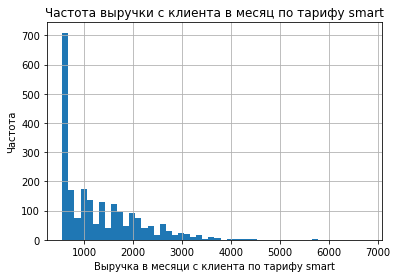

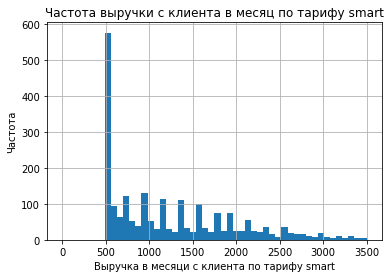

count    2230.000000
mean     1294.305381
std       820.900496
min       550.000000
25%       550.000000
50%      1037.000000
75%      1750.000000
max      6770.000000
Name: revenue_month, dtype: float64

In [47]:
calls_message_internet.query('tariff == "smart"')['revenue_month'].plot(kind='hist', grid=True, bins=50)
plt.title('Частота выручки с клиента в месяц по тарифу smart')
plt.xlabel('Выручка в месяци с клиента по тарифу smart')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff == "smart"')['revenue_month'].plot(kind='hist', range=(0,3500), grid=True, bins=50)
plt.title('Частота выручки с клиента в месяц по тарифу smart')
plt.xlabel('Выручка в месяци с клиента по тарифу smart')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff == "smart"')['revenue_month'].describe()

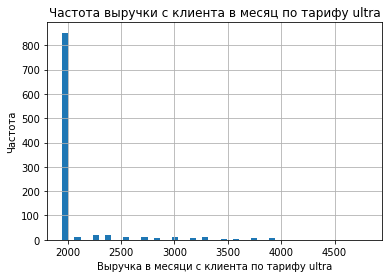

count     986.000000
mean     2070.943205
std       378.629673
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue_month, dtype: float64

In [48]:
calls_message_internet.query('tariff != "smart"')['revenue_month'].plot(kind='hist', grid=True, bins=50)
plt.title('Частота выручки с клиента в месяц по тарифу ultra')
plt.xlabel('Выручка в месяци с клиента по тарифу ultra')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff != "smart"')['revenue_month'].describe()

In [49]:
revenue_smart = calls_message_internet.query('tariff == "smart"')['revenue_month'].sum()
revenue_ultra = calls_message_internet.query('tariff != "smart"')['revenue_month'].sum()
delta_revenue_upsmart = revenue_smart - revenue_ultra
delta_revenue_upsmart_decimal = (revenue_smart - revenue_ultra) / (revenue_smart + revenue_ultra)

display(revenue_smart)
display(revenue_ultra)
display(delta_revenue_upsmart)
display(delta_revenue_upsmart_decimal)

2886301.0

2041950.0

844351.0

0.17132873305357216

Выручка тарифа smart по месяцам с пользователя в основном составляет 550 рублей (стоимость тарифа), пользователи, которые  переплачивают составляют более 50 % выборки ( в основном сумма к оплате у них (550; 2000) в примерно равном по частоте соотношении.
Выручка тарифа ultra по месяцам с пользователя почти всегда укладывается в тариф (более 80% случаев).
В сравнении средняя выручка с клиента у тарифа ultra на 777 рублей больше (38% от выручки тарифа ultra). 
Но зато клиентов с тарифом smart больше на 1244 человека (на 39% от общей выборки). За счет количества клиентов совокупная выручка по тарифму сматр выше, не смотря на то, что он намного дешевле ( разница в выручке 844 351 рубля (17% от общей выручки).

In [50]:
def over_minutes(row):
    if row['minutes_month'] > row['minutes_included']:
        row['over_traffick_min'] = row['minutes_month'] - row['minutes_included']
    else:
        row['over_traffick_min'] = 0
    return row['over_traffick_min']

In [51]:
def over_messages(row):
    if row['messages_id'] > row['messages_included']:
        row['over_traffick_mes'] = row['messages_id'] - row['messages_included']
    else:
        row['over_traffick_mes'] = 0
    return row['over_traffick_mes']

In [52]:
def over_mb(row):
    if row['mb_used'] > row['mb_per_month_included']:
        row['over_traffick_mb'] = row['mb_used'] - row['mb_per_month_included']
    else:
        row['over_traffick_mb'] = 0
    return row['over_traffick_mb']

In [53]:
calls_message_internet['over_minutes'] = calls_message_internet.apply(over_minutes, axis=1)
calls_message_internet['over_messages'] = calls_message_internet.apply(over_messages, axis=1)
calls_message_internet['over_mb'] = calls_message_internet.apply(over_mb, axis=1)
calls_message_internet

,user_id,month,call_month,minutes_month,messages_id,mb_used,churn_date,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_month,over_minutes,over_messages,over_mb
0,1000,5.0,17.0,159.0,22.0,2256.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
1,1000,6.0,28.0,172.0,60.0,23257.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
2,1000,7.0,41.0,340.0,75.0,14016.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
3,1000,8.0,42.0,408.0,81.0,14070.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
4,1000,9.0,46.0,466.0,57.0,14581.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,8.0,70.0,11.0,1848.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,550.0,0.0,0.0,0.0
3212,1499,10.0,44.0,449.0,48.0,17809.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1150.0,0.0,0.0,2449.0
3213,1499,11.0,62.0,612.0,59.0,17984.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1513.0,112.0,9.0,2624.0
3214,1499,12.0,56.0,492.0,66.0,13077.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,598.0,0.0,16.0,0.0


In [54]:
calls_message_internet['reg_month'] = calls_message_internet['reg_date'].dt.month
calls_message_internet.columns

Index(['user_id', 'month', 'call_month', 'minutes_month', 'messages_id',
       'mb_used', 'churn_date', 'city', 'reg_date', 'tariff',
       'messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'revenue_month', 'over_minutes', 'over_messages', 'over_mb',
       'reg_month'],
      dtype='object')

In [55]:
 # Поменял последовательность столбцов для удобства
cols = ['user_id', 'month', 'call_month', 'minutes_month', 'messages_id',
       'mb_used', 'churn_date', 'city', 'reg_date', 'tariff',
       'messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'revenue_month', 'over_minutes', 'over_messages', 'over_mb',
       'reg_month']

calls_message_internet = calls_message_internet.reindex(columns=cols)
calls_message_internet

,user_id,month,call_month,minutes_month,messages_id,mb_used,churn_date,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_month,over_minutes,over_messages,over_mb,reg_month
0,1000,5.0,17.0,159.0,22.0,2256.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5
1,1000,6.0,28.0,172.0,60.0,23257.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5
2,1000,7.0,41.0,340.0,75.0,14016.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5
3,1000,8.0,42.0,408.0,81.0,14070.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5
4,1000,9.0,46.0,466.0,57.0,14581.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,8.0,70.0,11.0,1848.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,550.0,0.0,0.0,0.0,9
3212,1499,10.0,44.0,449.0,48.0,17809.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1150.0,0.0,0.0,2449.0,9
3213,1499,11.0,62.0,612.0,59.0,17984.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1513.0,112.0,9.0,2624.0,9
3214,1499,12.0,56.0,492.0,66.0,13077.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,598.0,0.0,16.0,0.0,9


In [56]:
calls_message_internet['over_minutes_cash'] = calls_message_internet['over_minutes'] * calls_message_internet['rub_per_minute']
calls_message_internet['over_messages_cash'] = calls_message_internet['over_messages'] * calls_message_internet['rub_per_message']
# Вносим в таблицу значения перерасхода по опциям тарифа для более полного анализа

In [57]:
calls_message_internet['over_mb_cash'] = np.ceil(calls_message_internet['over_mb'] / 1024) * calls_message_internet['rub_per_gb']
display(calls_message_internet)
calls_message_internet.info()
# Вносим в таблицу значения перерасхода по опциям тарифа для более полного анализа

,user_id,month,call_month,minutes_month,messages_id,mb_used,churn_date,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_month,over_minutes,over_messages,over_mb,reg_month,over_minutes_cash,over_messages_cash,over_mb_cash
0,1000,5.0,17.0,159.0,22.0,2256.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
1,1000,6.0,28.0,172.0,60.0,23257.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
2,1000,7.0,41.0,340.0,75.0,14016.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
3,1000,8.0,42.0,408.0,81.0,14070.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
4,1000,9.0,46.0,466.0,57.0,14581.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,8.0,70.0,11.0,1848.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,550.0,0.0,0.0,0.0,9,0.0,0.0,0.0
3212,1499,10.0,44.0,449.0,48.0,17809.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1150.0,0.0,0.0,2449.0,9,0.0,0.0,600.0
3213,1499,11.0,62.0,612.0,59.0,17984.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1513.0,112.0,9.0,2624.0,9,336.0,27.0,600.0
3214,1499,12.0,56.0,492.0,66.0,13077.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,598.0,0.0,16.0,0.0,9,0.0,48.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 25 columns):
user_id                  3216 non-null int64
month                    3214 non-null float64
call_month               3168 non-null float64
minutes_month            3168 non-null float64
messages_id              2717 non-null float64
mb_used                  3203 non-null float64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
revenue_month            3216 non-null float64
over_minutes             3216 non-null float64
over_

In [58]:
calls_message_internet['minutes_month'] = calls_message_internet['minutes_month'].fillna(0)  
calls_message_internet['call_month'] = calls_message_internet['call_month'].fillna(0)
calls_message_internet['messages_id'] = calls_message_internet['messages_id'].fillna(0)
calls_message_internet['mb_used'] = calls_message_internet['mb_used'].fillna(0)
calls_message_internet.info()
# Предполагаю, что пропуски появились из-за того, что в других таблицах (сообщения, мб) были значения по данному
# пользователю, а в этом нет, но если не было звонков в месяц, то значит было потрачено в сумме 0 минут.
# Остальное по томуже принципу

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 25 columns):
user_id                  3216 non-null int64
month                    3214 non-null float64
call_month               3216 non-null float64
minutes_month            3216 non-null float64
messages_id              3216 non-null float64
mb_used                  3216 non-null float64
churn_date               189 non-null datetime64[ns]
city                     3216 non-null object
reg_date                 3216 non-null datetime64[ns]
tariff                   3216 non-null object
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
revenue_month            3216 non-null float64
over_minutes             3216 non-null float64
over_

In [59]:
mean = calls_message_internet.pivot_table(index='tariff', values=['minutes_month', 'messages_id', 'mb_used', 'revenue_month', 'over_minutes', 'over_messages', 'over_mb'], aggfunc='mean')
mean = np.ceil(mean)
mean
# Еще раз сводно все посмотреть, отобразив еще значения по перерасходу различных опций тарифа.

,mb_used,messages_id,minutes_month,over_mb,over_messages,over_minutes,revenue_month
tariff,,,,,,,
smart,16222.0,34.0,418.0,2770.0,6.0,42.0,1295.0
ultra,19468.0,50.0,527.0,754.0,0.0,0.0,2071.0


Видим, что пользователи двух разных тарифов (отличаются по цене  пакета почти на 400%) имеют не такой уж убольшой разброс в нуждах пользователей. Выходная же цена различается на 776 руб. итоговые цены приближаются из-за того, что пользователи тарифа smart больше используют опций сверх лимита (в основном интернет).

Дисперсия трафика по тарифу СМАРТ 34648523.30069166
Дисперсия трафика по тарифу УЛЬТРА 102217264.27537195
Стандартное отклонение трафика по тарифу СМАРТ 5886.299627158955
Стандартное отклонение трафика по тарифу УЛЬТРА 10110.255401095066
Среднее трафика по тарифу СМАРТ 16221.910762331838
Среднее трафика по тарифу УЛЬТРА 19467.137931034482


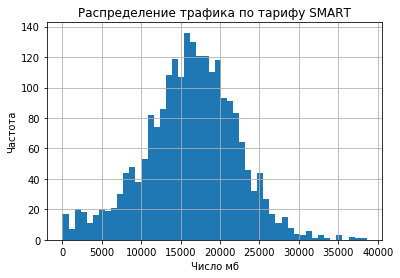

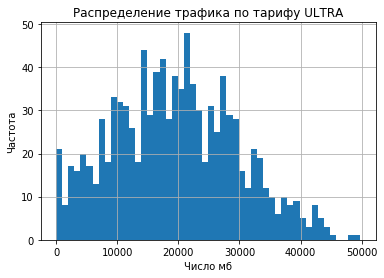

In [60]:
print('Дисперсия трафика по тарифу СМАРТ', np.var(calls_message_internet.query('tariff == "smart"')['mb_used'], ddof=1))
print('Дисперсия трафика по тарифу УЛЬТРА', np.var(calls_message_internet.query('tariff == "ultra"')['mb_used'], ddof=1))
print('Стандартное отклонение трафика по тарифу СМАРТ', np.std(calls_message_internet.query('tariff == "smart"')['mb_used'], ddof=1))
print('Стандартное отклонение трафика по тарифу УЛЬТРА', np.std(calls_message_internet.query('tariff == "ultra"')['mb_used'], ddof=1))
print('Среднее трафика по тарифу СМАРТ', calls_message_internet.query('tariff == "smart"')['mb_used'].mean())
print('Среднее трафика по тарифу УЛЬТРА', calls_message_internet.query('tariff == "ultra"')['mb_used'].mean())
calls_message_internet.query('tariff == "smart"')['mb_used'].plot(kind='hist', grid=True, bins=50)
plt.title('Распределение трафика по тарифу SMART')
plt.xlabel('Число мб')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff != "smart"')['mb_used'].plot(kind='hist', grid=True, bins=50)
plt.title('Распределение трафика по тарифу ULTRA')
plt.xlabel('Число мб')
plt.ylabel('Частота')
plt.show()

Дисперсия сообщений по тарифу СМАРТ 796.9552557301128
Дисперсия сообщений по тарифу УЛЬТРА 2285.4174246558414
Стандартное отклонение сообщений по тарифу СМАРТ 28.23039595418585
Стандартное отклонение сообщений по тарифу УЛЬТРА 47.80603962530092
Среднее сообщений по тарифу СМАРТ 33.36905829596412
Среднее сообщений по тарифу УЛЬТРА 49.31338742393509


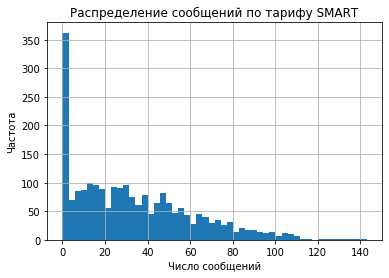

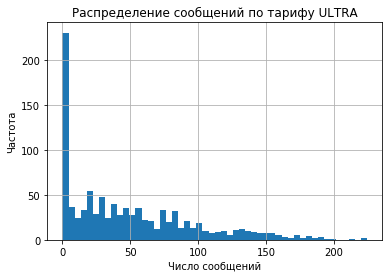

In [61]:
print('Дисперсия сообщений по тарифу СМАРТ', np.var(calls_message_internet.query('tariff == "smart"')['messages_id'], ddof=1))
print('Дисперсия сообщений по тарифу УЛЬТРА', np.var(calls_message_internet.query('tariff == "ultra"')['messages_id'], ddof=1))
print('Стандартное отклонение сообщений по тарифу СМАРТ', np.std(calls_message_internet.query('tariff == "smart"')['messages_id'], ddof=1))
print('Стандартное отклонение сообщений по тарифу УЛЬТРА', np.std(calls_message_internet.query('tariff == "ultra"')['messages_id'], ddof=1))
print('Среднее сообщений по тарифу СМАРТ', calls_message_internet.query('tariff == "smart"')['messages_id'].mean())
print('Среднее сообщений по тарифу УЛЬТРА', calls_message_internet.query('tariff == "ultra"')['messages_id'].mean())
calls_message_internet.query('tariff == "smart"')['messages_id'].plot(kind='hist', grid=True, bins=50)
plt.title('Распределение сообщений по тарифу SMART')
plt.xlabel('Число сообщений')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff != "smart"')['messages_id'].plot(kind='hist', grid=True, bins=50)
plt.title('Распределение сообщений по тарифу ULTRA')
plt.xlabel('Число сообщений')
plt.ylabel('Частота')
plt.show()

Дисперсия минут по тарифу СМАРТ 36281.39383644458
Дисперсия минут по тарифу УЛЬТРА 101052.49354928388
Стандартное отклонение минут по тарифу СМАРТ 190.4767540579285
Стандартное отклонение минут по тарифу УЛЬТРА 317.8875485911392
Среднее минут по тарифу СМАРТ 417.747533632287
Среднее минут по тарифу УЛЬТРА 526.0892494929006


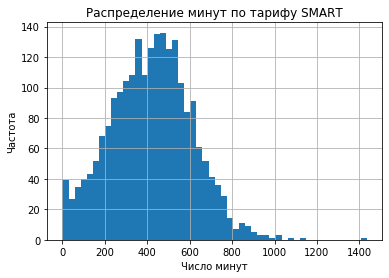

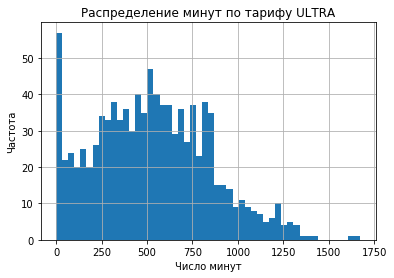

In [62]:
print('Дисперсия минут по тарифу СМАРТ', np.var(calls_message_internet.query('tariff == "smart"')['minutes_month'], ddof=1))
print('Дисперсия минут по тарифу УЛЬТРА', np.var(calls_message_internet.query('tariff == "ultra"')['minutes_month'], ddof=1))
print('Стандартное отклонение минут по тарифу СМАРТ', np.std(calls_message_internet.query('tariff == "smart"')['minutes_month'], ddof=1))
print('Стандартное отклонение минут по тарифу УЛЬТРА', np.std(calls_message_internet.query('tariff == "ultra"')['minutes_month'], ddof=1))
print('Среднее минут по тарифу СМАРТ', calls_message_internet.query('tariff == "smart"')['minutes_month'].mean())
print('Среднее минут по тарифу УЛЬТРА', calls_message_internet.query('tariff == "ultra"')['minutes_month'].mean())
calls_message_internet.query('tariff == "smart"')['minutes_month'].plot(kind='hist', grid=True, bins=50)
plt.title('Распределение минут по тарифу SMART')
plt.xlabel('Число минут')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff != "smart"')['minutes_month'].plot(kind='hist', grid=True, bins=50)
plt.title('Распределение минут по тарифу ULTRA')
plt.xlabel('Число минут')
plt.ylabel('Частота')
plt.show()

Дисперсия выручки по тарифу СМАРТ 673877.6236139194
Дисперсия выручки по тарифу УЛЬТРА 143360.42925834784
Стандартное отклонение выручки по тарифу СМАРТ 820.9004955619891
Стандартное отклонение выручки по тарифу УЛЬТРА 378.6296729765746
Среднее выручки по тарифу СМАРТ 1294.3053811659192
Среднее выручки по тарифу УЛЬТРА 2070.943204868154


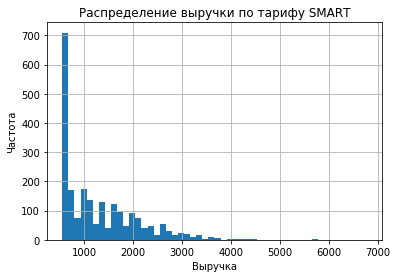

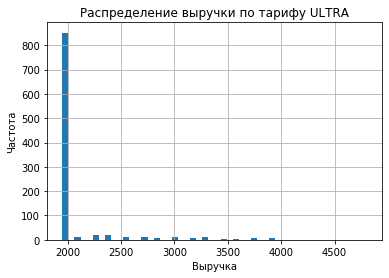

In [63]:
print('Дисперсия выручки по тарифу СМАРТ', np.var(calls_message_internet.query('tariff == "smart"')['revenue_month'], ddof=1))
print('Дисперсия выручки по тарифу УЛЬТРА', np.var(calls_message_internet.query('tariff == "ultra"')['revenue_month'], ddof=1))
print('Стандартное отклонение выручки по тарифу СМАРТ', np.std(calls_message_internet.query('tariff == "smart"')['revenue_month'], ddof=1))
print('Стандартное отклонение выручки по тарифу УЛЬТРА', np.std(calls_message_internet.query('tariff == "ultra"')['revenue_month'], ddof=1))
print('Среднее выручки по тарифу СМАРТ', calls_message_internet.query('tariff == "smart"')['revenue_month'].mean())
print('Среднее выручки по тарифу УЛЬТРА', calls_message_internet.query('tariff == "ultra"')['revenue_month'].mean())
calls_message_internet.query('tariff == "smart"')['revenue_month'].plot(kind='hist', grid=True, bins=50)
plt.title('Распределение выручки по тарифу SMART')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()
calls_message_internet.query('tariff != "smart"')['revenue_month'].plot(kind='hist', grid=True, bins=50)
plt.title('Распределение выручки по тарифу ULTRA')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()


In [64]:
calls_message_internet

,user_id,month,call_month,minutes_month,messages_id,mb_used,churn_date,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue_month,over_minutes,over_messages,over_mb,reg_month,over_minutes_cash,over_messages_cash,over_mb_cash
0,1000,5.0,17.0,159.0,22.0,2256.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
1,1000,6.0,28.0,172.0,60.0,23257.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
2,1000,7.0,41.0,340.0,75.0,14016.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
3,1000,8.0,42.0,408.0,81.0,14070.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
4,1000,9.0,46.0,466.0,57.0,14581.0,NaT,Краснодар,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0,0.0,0.0,0.0,5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,8.0,70.0,11.0,1848.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,550.0,0.0,0.0,0.0,9,0.0,0.0,0.0
3212,1499,10.0,44.0,449.0,48.0,17809.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1150.0,0.0,0.0,2449.0,9,0.0,0.0,600.0
3213,1499,11.0,62.0,612.0,59.0,17984.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,1513.0,112.0,9.0,2624.0,9,336.0,27.0,600.0
3214,1499,12.0,56.0,492.0,66.0,13077.0,NaT,Пермь,2018-09-27,smart,50,15360,500,550,200,3,3,598.0,0.0,16.0,0.0,9,0.0,48.0,0.0


Видим, что дисперсия и стандартное отклонение в минутах, сообщениях и мб, затраченных пользователями разных тарифов отличается почти в 2 раза. Это говорит о том, что разброс значений в данных колонках по тарифу ультра больше, чем по smart. Противоположная ситуация по общей цене (в тарифе смарт стандартное отклонение выше больше чем в 2 раза) и перерасходу (интернет на треть, отклонения по мб и сообщениям в тарифе ультра = ).

## Проверка гипотез

<a id='Проверка_гипотез'></a>

count    2230.000000
mean     1294.305381
std       820.900496
min       550.000000
25%       550.000000
50%      1037.000000
75%      1750.000000
max      6770.000000
Name: revenue_month, dtype: float64

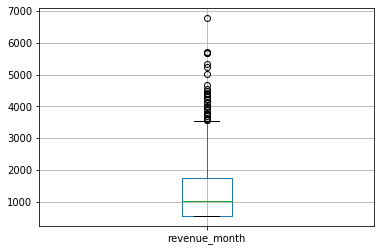

In [66]:
calls_message_internet.query('tariff == "smart"').boxplot(column='revenue_month')  #Узнать как определить границу  для выбросов в конкретном числе (а не схематично на графике)
calls_message_internet.query('tariff == "smart"')['revenue_month'].describe()

In [67]:
calls_message_internet_clear_smart = calls_message_internet.query('tariff == "smart" and revenue_month < 3500')['revenue_month']

count     986.000000
mean     2070.943205
std       378.629673
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue_month, dtype: float64

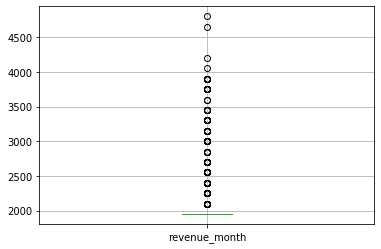

In [68]:
calls_message_internet.query('tariff != "smart"').boxplot(column='revenue_month')  #Узнать как определить границу  для выбросов в конкретном числе (а не схематично на графике)
calls_message_internet.query('tariff != "smart"')['revenue_month'].describe()

In [69]:
calls_message_internet_clear_ultra = calls_message_internet.query('tariff != "smart" and revenue_month == 1950')['revenue_month']

### Нулевая гипотеза 1(H0): Cредняя выручка пользователей тарифов «Ультра» и «Смарт» равна.

Алтернативная гипотеза 1(H1): Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается (не равна).

In [70]:
smart = calls_message_internet_clear_smart
ultra = calls_message_internet_clear_ultra

alpha = .05

hypothesis_1 = st.ttest_ind(smart, ultra, equal_var = False)

print('p-значение:', hypothesis_1.pvalue)

if (hypothesis_1.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.5725e-319
Отвергаем нулевую гипотезу


В Т-Тесте использовали equal_var = False, так как дисперсии выборок сильно различаются.

### Нулевая гипотеза 2 (H0):  Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

Алтернативная гипотеза 2 (H1): Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [71]:
calls_message_internet.query('(tariff == "smart" and revenue_month < 3500) or (tariff != "smart" and revenue_month == 1950)')['revenue_month']

0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3211     550.0
3212    1150.0
3213    1513.0
3214     598.0
3215     550.0
Name: revenue_month, Length: 3046, dtype: float64

In [72]:
print('Дисперсия выручки по Москве', np.var(calls_message_internet.query('city == "Москва" and ((tariff == "smart" and revenue_month < 3500) or (tariff != "smart" and revenue_month == 1950))')['revenue_month'], ddof=1))
print('Дисперсия выручки по всем кроме Москвы', np.var(calls_message_internet.query('city != "Москва" and ((tariff == "smart" and revenue_month < 3500) or (tariff != "smart" and revenue_month == 1950))')['revenue_month'], ddof=1))

Дисперсия выручки по Москве 449122.190254094
Дисперсия выручки по всем кроме Москвы 485906.3066598075


In [73]:
moscow = calls_message_internet.query('city == "Москва"')['revenue_month']
all_without_moscow = calls_message_internet.query('city != "Москва"')['revenue_month']

alpha = .05

hypothesis_2 = st.ttest_ind(moscow, all_without_moscow, equal_var = True)

print('p-значение:', hypothesis_2.pvalue)

if (hypothesis_2.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.5277299573181309
Не получилось отвергнуть нулевую гипотезу


В Т-Тесте использовали equal_var = True, так как дисперсии выборок не сильно различаются.

Формулировал нулевую и альтернативную гипотезы исходя из задания и того, чтобы нулевая гипотеза формулировалась так чтобы бы был использован знак равенства.
Для проверки гипотез использовали т-тест, а именно метод st.ttest_ind, так как мы работаем с выборкой, а не генеральной совокупностью и у нас значений относительно немного.

## Общий вывод

<a id='Общий_вывод'></a>

Пользователи тарифа smart чаще всего тратят 250-600 минут на разговоры в месяц (при заявленных в тарифе 500), 0-45 сообщений в месяц (при доступных 50) и 12500 - 22500 мб интернета в месяц ( при заявленных 15360). 

Подавляющее число пользователей тарфиа ultra тратят 15000 - 27000 мб в месяц, при 30720 доступных мб. в тарифе. Чуть меньше 25% людей тратят больше трафика чем заявленно в тарифе. Подавляющее число пользователей тарфиа ultra отпарвляют в месяц 0-80 сообщений из заявленных в тарифе 1000. В основном тратят в месяц 250-800 минут, реже больше, максимум 1673 минуты и никто не тратит 3000 минут, данные в тарифе.

Выручка тарифа smart по месяцам с пользователя в основном составляет 550 рублей (стоимость тарифа), пользователи, которые  переплачивают составляют более 50 % выборки ( в основном сумма к оплате у них (550; 2000) в примерно равном по частоте соотношении.

Выручка тарифа ultra по месяцам с пользователя почти всегда укладывается в тариф (более 80% случаев).
В сравнении средняя выручка с клиента у тарифа ultra на 777 рублей больше (38% от выручки тарифа ultra). 

Но зато клиентов с тарифом smart больше на 1244 человека (на 39% от общей выборки). За счет количества клиентов совокупная выручка по тарифму сматр выше, не смотря на то, что он намного дешевле ( разница в выручке 844 351 рубля (17% от общей выручки).

Проверили гипотезу равенства средней выручки двух тарифов и пришли к выводу, что  скорей эти показатели сильно различаются. Гипотеза, что выручка по Москве отличается от выручки в других регионах - не верна.

В абсолютном выражении больше денег приносит тариф smart, за счет большего количества пользователей. Выручка на пользователя в среднем больше у тарифа ultra (в среднем на 777 рублей). Следовательно необходимо просчитать сколько денег потребуется для привлечения пользовательей разных тарифов, посчитать разницу и сравнить с выручкой по тарифам с учетом времени пользования тарифом (время котолрое человек пользуется тарифом, затем возможно меняет его, уходит к конкурентам и т.д.). Опираться на пользователей в Москве, исходя из того, что там средняя выручка на клиента больше - ошибка. Возможно в Москве более платежеспособное население и много людей, но платят они на уровне с остальными. 